In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.stats import ttest_ind

In [2]:
test = pd.read_csv('test_results.csv')
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [3]:
test.timestamp = pd.to_datetime(test.timestamp,errors='ignore')

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [6]:
print("Users were shown the 59 but in control group",(test[test.test == 0]['price'] != 39).sum())
test[(test.test == 0)&~(test['price'] == 39)].head()

Users were shown the 59 but in control group 210


,user_id,timestamp,source,device,operative_system,test,price,converted
8238,500863,2015-05-06 22:40:51,ads_other,mobile,iOS,0,59,0
8369,791541,2015-04-13 10:24:19,ads-bing,web,windows,0,59,0
11555,402699,2015-05-16 12:08:45,direct_traffic,mobile,other,0,59,0
12848,624380,2015-05-22 12:37:19,seo-google,mobile,iOS,0,59,0
14630,577544,2015-04-24 17:44:57,seo-google,mobile,android,0,59,0


In [7]:
print("Users were shown the 39 but in experimental group",(test[test.test == 1]['price'] != 59).sum())
test[(test.test == 1)&~(test['price'] == 59)].head()

Users were shown the 39 but in experimental group 155


,user_id,timestamp,source,device,operative_system,test,price,converted
1457,686486,2015-03-28 15:26:19,seo-other,mobile,android,1,39,0
1912,128338,2015-05-15 11:41:49,direct_traffic,mobile,android,1,39,0
2337,220590,2015-03-27 12:31:43,ads-google,web,windows,1,39,0
3147,246390,2015-05-30 08:29:44,direct_traffic,mobile,iOS,1,39,0
4277,906451,2015-04-05 11:09:18,ads-google,web,windows,1,39,0


Drop the discrepencies. We got enough data so we can delete the misunderstanding data.

In [8]:
test = test.drop(test[(test.test == 1)&~(test['price'] == 59)].index)
test = test.drop(test[(test.test == 0)&~(test['price'] == 39)].index)
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [9]:
print('The control group is',(test.test == 0).sum()/test.shape[0])
print('The test group is', (test.test == 1).sum()/test.shape[0])
con_ratio = (test.test == 0).sum()/test.shape[0]
test_ratio = 1-con_ratio

The control group is 0.6399955757106515
The test group is 0.36000442428934853


In [10]:
print('The control group"s conversion rate is',test[test.test == 0].converted.mean())
print('The test group"s conversion rate is',test[test.test == 1].converted.mean())

The control group"s conversion rate is 0.019899563987220825
The test group"s conversion rate is 0.01555504836812444


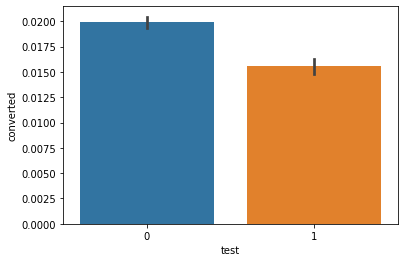

In [11]:
sns.barplot(x = 'test', y = 'converted', data = test)

The test group's conversion rate is significantly lower than the control group because of the incresed price.

In [12]:
test['value'] = test.converted * test.price
test_rev = test[test.test == 1].value.sum() / test_ratio 
con_rev = test[test.test == 0].value.sum() / con_ratio

<BarContainer object of 2 artists>

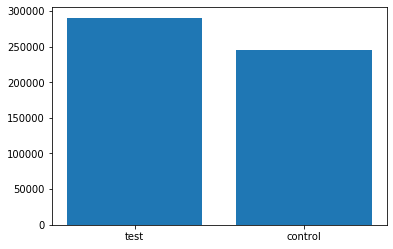

In [13]:
plt.bar(x=['test','control'], height=[test_rev,con_rev])

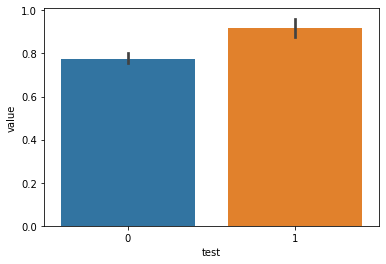

In [14]:
sns.barplot(x = test.test, y = test.value)

According to the graph, we could increase the price if the VP cares more about the total revenue. Otherwise, we need to consider more before we made the final desicion.

## Visualization

### Source

In [15]:
_ = test.groupby('test')['source'].value_counts().unstack()
_.head()

source,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,14584,37845,4812,34074,19256,38712,13121,1329,15088,5879,4356,13461
1,8247,21497,2759,19281,10570,21560,7557,815,8060,3365,2485,7722


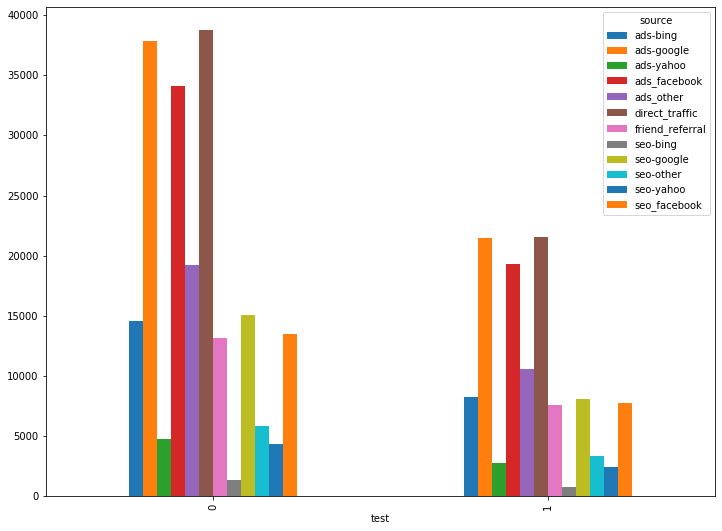

In [16]:
fig, ax = plt.subplots(figsize = (12,9))
_.plot(kind = 'bar', ax = ax)
plt.show()

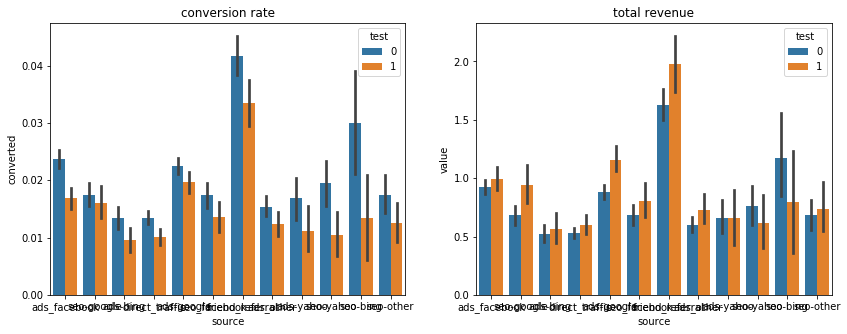

In [18]:
fig, ax = plt.subplots(1,2, figsize = (14,5))
sns.barplot(x = 'source', y = 'converted', data = test, hue = 'test', ax = ax[0])
sns.barplot(x = 'source', y = 'value', data = test, hue = 'test', ax = ax[1])
ax[0].set_title('conversion rate')
ax[1].set_title('total revenue')
plt.show()

The users's source in yahoo or bing is small segments that test group value are smaller than the control group.

### Operative System

In [19]:
test.groupby('operative_system')['value'].mean().sort_values(ascending = False)

operative_system
mac        1.083177
iOS        1.011515
windows    0.765384
android    0.670001
other      0.584163
linux      0.321065
Name: value, dtype: float64

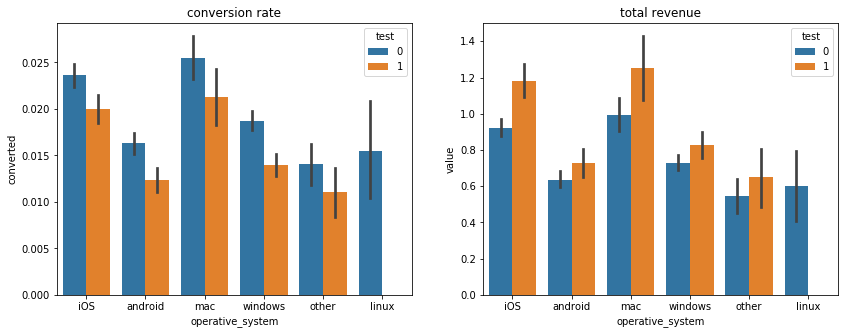

In [20]:
fig, ax = plt.subplots(1,2, figsize = (14,5))
sns.barplot(x = 'operative_system', y = 'converted', data = test, hue = 'test', ax = ax[0])
sns.barplot(x = 'operative_system', y = 'value', data = test, hue = 'test', ax = ax[1])
ax[0].set_title('conversion rate')
ax[1].set_title('total revenue')
plt.show()

The conversion rate and total revenue are both indicate big different. The product's revenue is higher when it comes to users who using IOS and Mac system this might because they care more about the product instead of price. However, we need to check the system especially users who are using Linux system because we couldn't receive any linux system data in test group.

## Device

In [21]:
test.groupby('device')['value'].mean().sort_values(ascending = False)

device
mobile    0.837851
web       0.811674
Name: value, dtype: float64

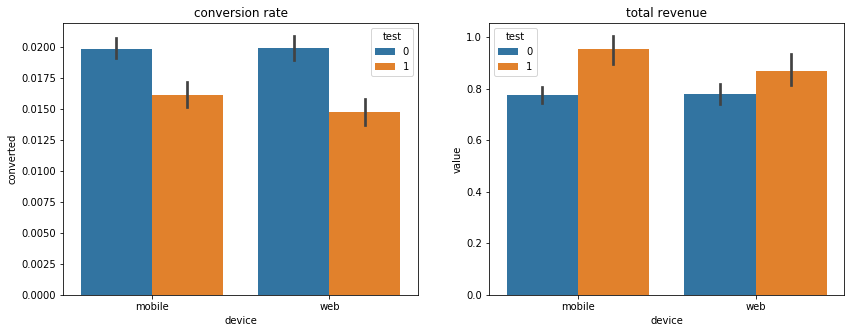

In [22]:
fig, ax = plt.subplots(1,2, figsize = (14,5))
sns.barplot(x = 'device', y = 'converted', data = test, hue = 'test', ax = ax[0])
sns.barplot(x = 'device', y = 'value', data = test, hue = 'test', ax = ax[1])
ax[0].set_title('conversion rate')
ax[1].set_title('total revenue')
plt.show()

No big difference between mobile and web device.

## Hypothesis Testing:

Null Hypothesis (H0) : experimental group's average revenue is less than or equal to the control group's.
Alternative Hypothesis (H1) : experimental group's average revenue is larger the control group's.

In [23]:
ttest_ind(test[test.test == 0]['value'],test[test.test == 1]['value'],axis =0, equal_var=False)

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)

We can tell from the results that we can reject the H0 which means test group's average revenue is higher than control group's average revenue.

Although, we can conclude that incresing the price can bring us higher revenue but we still need to consider the problem with A/B Testing.

In [24]:
user = pd.read_csv('user_table_price.csv')
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [25]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [26]:
dt = test.copy()
dt.timestamp = dt.timestamp.str.split(" ",  expand = True)[0]
dt.timestamp = pd.to_datetime(dt.timestamp)
dt['week'] = dt.timestamp.apply(lambda x : x.dayofweek)

In [27]:
dt = dt.drop(['timestamp','device','user_id','test','value'], axis = 1)
dt.head()

,source,operative_system,price,converted,week
0,ads_facebook,iOS,39,0,4
1,seo-google,android,39,0,6
2,ads-bing,android,39,0,5
3,direct_traffic,iOS,59,0,3
4,ads_facebook,mac,39,0,6


In [28]:
dt.source.value_counts()

direct_traffic     60272
ads-google         59342
ads_facebook       53355
ads_other          29826
seo-google         23148
ads-bing           22831
seo_facebook       21183
friend_referral    20678
seo-other           9244
ads-yahoo           7571
seo-yahoo           6841
seo-bing            2144
Name: source, dtype: int64

In [29]:
dt['source'] = dt.source.str.replace('-','_').str.split('_',expand = True)[0]

In [30]:
dt = pd.get_dummies(dt)
dt.head()

,price,converted,week,source_ads,source_direct,source_friend,source_seo,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows
0,39,0,4,1,0,0,0,0,1,0,0,0,0
1,39,0,6,0,0,0,1,1,0,0,0,0,0
2,39,0,5,1,0,0,0,1,0,0,0,0,0
3,59,0,3,0,1,0,0,0,1,0,0,0,0
4,39,0,6,1,0,0,0,0,0,0,1,0,0


In [31]:
x_train = dt.loc[:,dt.columns != 'converted',]
y_train = dt.loc[:,'converted']
x_train.head()

,price,week,source_ads,source_direct,source_friend,source_seo,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows
0,39,4,1,0,0,0,0,1,0,0,0,0
1,39,6,0,0,0,1,1,0,0,0,0,0
2,39,5,1,0,0,0,1,0,0,0,0,0
3,59,3,0,1,0,0,0,1,0,0,0,0
4,39,6,1,0,0,0,0,0,0,1,0,0


In [32]:
from graphviz import Source
dtree = DecisionTreeClassifier(max_depth= 3)
dtree.fit(x_train, y_train)
graph = Source(export_graphviz(dtree, feature_names= x_train.columns, proportion= True, leaves_parallel= True))

In [33]:
pd.Series(dtree.feature_importances_, index= x_train.columns).sort_values(ascending= False)

source_friend               0.664478
operative_system_iOS        0.143629
operative_system_mac        0.106823
source_direct               0.042272
price                       0.023435
operative_system_linux      0.019364
operative_system_windows    0.000000
operative_system_other      0.000000
operative_system_android    0.000000
source_seo                  0.000000
source_ads                  0.000000
week                        0.000000
dtype: float64

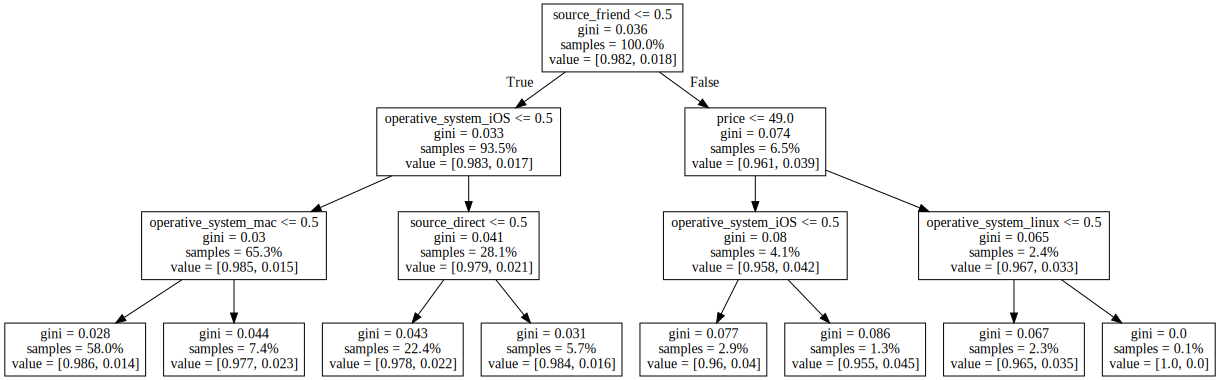

In [34]:
from IPython.display import SVG
SVG(graph.pipe(format = 'svg'))

From above tree plot, we can see that, from root to leaf node with highest conversion rate, the path is :

1. source by friend referral
2. system is IOS or not
3. price is 39 or 59